<a href="https://colab.research.google.com/github/kdemertzis/Hydroinformatics/blob/main/01_basic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Basic Model

In this example application it is shown how a simple time series model can be developed to simulate groundwater levels. The recharge (calculated as precipitation minus evaporation) is used as the explanatory time series.

In [3]:
!pip install pastas

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

import pastas as ps

ps.show_versions()

Python version: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Numpy version: 1.19.5
Scipy version: 1.4.1
Pandas version: 1.1.5
Pastas version: 0.18.0
Matplotlib version: 3.2.2


### 1. Importing the dependent time series data
In this codeblock a time series of groundwater levels is imported using the `read_csv` function of `pandas`. As `pastas` expects a `pandas` `Series` object, the data is squeezed. To check if you have the correct data type (a `pandas Series` object), you can use `type(oseries)` as shown below. 

The following characteristics are important when importing and preparing the observed time series:
- The observed time series are stored as a `pandas Series` object.
- The time step can be irregular.

The data type of the oseries is: <class 'pandas.core.series.Series'>


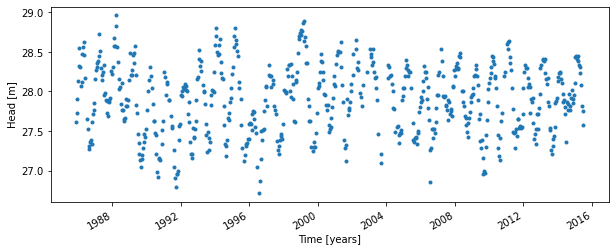

In [5]:
# Import groundwater time seriesm and squeeze to Series object
gwdata = pd.read_csv('https://raw.githubusercontent.com/kdemertzis/Hydroinformatics/main/data/head_nb1.csv', parse_dates=['date'],
                     index_col='date', squeeze=True)
print('The data type of the oseries is: %s' % type(gwdata))

# Plot the observed groundwater levels
gwdata.plot(style='.', figsize=(10, 4))
plt.ylabel('Head [m]');
plt.xlabel('Time [years]');

### 2. Import the independent time series
Two explanatory series are used: the precipitation and the potential evaporation. These need to be `pandas Series` objects, as for the observed heads.

Important characteristics of these time series are:
- All series are stored as `pandas Series` objects.
- The series may have irregular time intervals, but then it will be converted to regular time intervals when creating the time series model later on.
- It is preferred to use the same length units as for the observed heads.

The data type of the precip series is: <class 'pandas.core.series.Series'>
The data type of the evap series is: <class 'pandas.core.series.Series'>
The data type of the recharge series is: <class 'pandas.core.series.Series'>


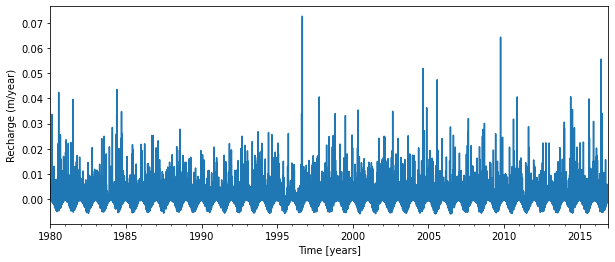

In [6]:
# Import observed precipitation series
precip = pd.read_csv('https://raw.githubusercontent.com/kdemertzis/Hydroinformatics/main/data/rain_nb1.csv', parse_dates=['date'],
                     index_col='date', squeeze=True)
print('The data type of the precip series is: %s' % type(precip))

# Import observed evaporation series
evap = pd.read_csv('https://raw.githubusercontent.com/kdemertzis/Hydroinformatics/main/data/evap_nb1.csv', parse_dates=['date'],
                   index_col='date', squeeze=True)
print('The data type of the evap series is: %s' % type(evap))

# Calculate the recharge to the groundwater
recharge = precip - evap
print('The data type of the recharge series is: %s' % type(recharge))

# Plot the time series of the precipitation and evaporation
plt.figure()
recharge.plot(label='Recharge', figsize=(10, 4))
plt.xlabel('Time [years]')
plt.ylabel('Recharge (m/year)');


### 3. Create the time series model
In this code block the actual time series model is created. First, an instance of the `Model` class is created (named `ml` here). Second, the different components of the time series model are created and added to the model. The imported time series are automatically checked for missing values and other inconsistencies. The keyword argument fillnan can be used to determine how missing values are handled. If any nan-values are found this will be reported by `pastas`.

In [7]:
# Create a model object by passing it the observed series
ml = ps.Model(gwdata, name="GWL")

# Add the recharge data as explanatory variable
sm = ps.StressModel(recharge, ps.Gamma, name='recharge', settings="evap")
ml.add_stressmodel(sm)

INFO: Cannot determine frequency of series head: freq=None. The time series is irregular.
INFO: Nan-values were removed at the end of the time series None.
INFO: Inferred frequency for time series None: freq=D


### 4. Solve the model
The next step is to compute the optimal model parameters. The default solver  uses a non-linear least squares method for the optimization. The python package `scipy` is used (info on `scipy's` least_squares solver can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html)). Some standard optimization statistics are reported along with the optimized parameter values and correlations.

In [8]:
ml.solve()

INFO: Time Series None was extended to 1975-11-17 00:00:00 with the mean value of the time series.


Fit report GWL                      Fit Statistics
nfev    20                     EVP           91.28
nobs    644                    R2             0.91
noise   True                   RMSE           0.13
tmin    1985-11-14 00:00:00    AIC        -3234.20
tmax    2015-06-28 00:00:00    BIC        -3211.87
freq    D                      Obj            2.09
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (5 optimized)
                optimal   stderr     initial  vary
recharge_A   753.594052   ±5.17%  215.674528  True
recharge_n     1.054415   ±1.50%    1.000000  True
recharge_a   135.886107   ±7.05%   10.000000  True
constant_d    27.552232   ±0.08%   27.900078  True
noise_alpha   61.768390  ±12.66%   15.000000  True


### 5. Plot the results
The solution can be plotted after a solution has been obtained.

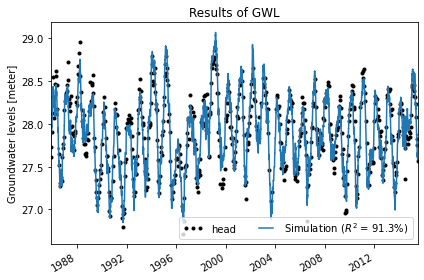

In [9]:
ml.plot()

### 6. Advanced plotting
There are many ways to further explore the time series model. `pastas` has some built-in functionalities that will provide the user with a quick overview of the model. The `plots` subpackage contains all the options. One of these is the method `plots.results` which provides a plot with more information.

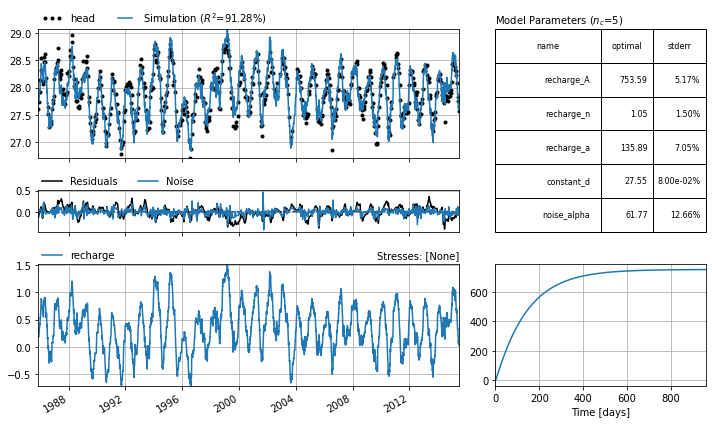

In [10]:
ml.plots.results(figsize=(10, 6))

### 7. Statistics
The `stats` subpackage includes a number of statistical functions that may applied to the model. One of them is the `summary` method, which gives a summary of the main statistics of the model.

In [11]:
ml.stats.summary()

,Value
Statistic,
rmse,0.126901
rmsn,0.080897
sse,10.370885
mae,0.101293
nse,0.912832
evp,91.283346
rsq,0.912832
bic,-3211.865321
aic,-3234.203815


### 8. Improvement: estimate evaporation factor
In the previous model, the recharge was estimated as precipitation minus potential evaporation. A better model is to estimate the actual evaporation as a factor (called the evaporation factor here) times the potential evaporation. First, new model is created (called `ml2` here so that the original model `ml` does not get overwritten). Second, the `RechargeModel` object with a `Linear` recharge model is created, which combines the precipitation and evaporation series and adds a parameter for the evaporation factor `f`. The `RechargeModel` object is added to the model, the model is solved, and the results and statistics are plotted to the screen. Note that the new model gives a better fit (lower root mean squared error and higher explained variance), but that the Akiake information criterion indicates that the addition of the additional parameter does not improve the model signficantly (the Akaike criterion for model `ml2` is higher than for model `ml`).

INFO: Cannot determine frequency of series head: freq=None. The time series is irregular.
INFO: Inferred frequency for time series rain: freq=D
INFO: Inferred frequency for time series evap: freq=D
INFO: Time Series rain was extended to 1975-11-17 00:00:00 with the mean value of the time series.
INFO: Time Series evap was extended to 1975-11-17 00:00:00 with the mean value of the time series.
/usr/local/lib/python3.7/dist-packages/pastas/model.py:1658: RuntimeWarning: invalid value encountered in log10
  atol = np.min([1e-8, 10**(np.round(np.log10(pmin)) - 1)])


Fit report head                     Fit Statistics
nfev    22                     EVP           92.90
nobs    644                    R2             0.93
noise   True                   RMSE           0.11
tmin    1985-11-14 00:00:00    AIC        -3256.86
tmax    2015-06-28 00:00:00    BIC        -3230.05
freq    D                      Obj            2.01
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr     initial  vary
rainevap_A   682.471526   ±5.24%  215.674528  True
rainevap_n     1.018207   ±1.78%    1.000000  True
rainevap_a   150.381349   ±7.48%   10.000000  True
rainevap_f    -1.271036   ±4.77%   -1.000000  True
constant_d    27.882269   ±0.24%   27.900078  True
noise_alpha   50.095222  ±11.90%   15.000000  True


,Value
Statistic,
rmse,0.114492
rmsn,0.079510
sse,8.441844
mae,0.090257
nse,0.929046
evp,92.904629
rsq,0.929046
bic,-3230.051301
aic,-3256.857494


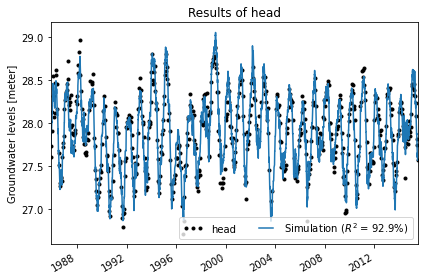

In [12]:
# Create a model object by passing it the observed series
ml2 = ps.Model(gwdata)

# Add the recharge data as explanatory variable
ts1 = ps.RechargeModel(precip, evap, ps.Gamma, name='rainevap', 
                       recharge=ps.rch.Linear(), settings=("prec", "evap"))
ml2.add_stressmodel(ts1)

# Solve the model
ml2.solve()

# Plot the results
ml2.plot()

# Statistics
ml2.stats.summary()

### Origin of the series
* The rainfall data is taken from rainfall station Heibloem in The Netherlands.
* The evaporation data is taken from weather station Maastricht in The Netherlands.
* The head data is well B58C0698, which was obtained from Dino loket